In [56]:
import os
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import openai
import re
import time
from azure.storage.blob import BlobServiceClient
#import fitz 
#from docx import Document
import pytesseract
from PIL import Image
import io
from azure.cosmos import CosmosClient, exceptions
import argparse
import pdfplumber
import io
import os
import logging
from pydantic import BaseModel
from langgraph.graph import StateGraph
import random
from typing import Literal
from langgraph.graph import START, END
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import spacy
from sentence_transformers import SentenceTransformer
#from annoy import AnnoyIndex
import faiss
from typing import Optional, Annotated, Dict, Any
from typing_extensions import Annotated
from pathlib import Path
import glob
import math

In [33]:
nltk.download('stopwords')
stemmer = SnowballStemmer('spanish')
stop_words = set(stopwords.words('spanish'))
palabras_irrelevantes = {'cordoba', 'distrital', 'solicitud', 'petición', 'ciudad', 'fiscalizacion'}  #Palabras sin significado clave
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("spanish"))
#nlp = spacy.load("es_core_news_sm")  # Modelo de spaCy para español
nlp = spacy.load("es_core_news_sm")  # Modelo de spaCy para español

nltk.download('wordnet')
#nltk.download('stopwords')
nltk.download('stopwords')
stemmer = SnowballStemmer('spanish')

#Inicializar el modelo de embeddings
embedding_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

#Entidades de referencia y convertimos a tipo float32 para FAISS
entidades = ["Fiscalización caso 1", "Fiscalización caso 2", "Fiscalización caso 3", "Fiscalización caso 4"]
categoria_embeddings = embedding_model.encode(entidades)
categoria_embeddings = np.array(categoria_embeddings).astype('float32')

d = categoria_embeddings.shape[1]  #Dimensión de los embeddings
faiss_index = faiss.IndexFlatL2(d)  #Índice L2 (distancia euclidiana)
faiss_index.add(categoria_embeddings)  #Agregar los embeddings al índice

faiss.write_index(faiss_index, "faiss_index.bin")

#Credenciales OpenAI:
openai.api_type = "azure"
openai.api_base = "https://ai-danielvallejosai0530531063088720.openai.azure.com/"
openai.api_version = "2024-12-01-preview"
openai.api_key = "EARAfege87W1E3y9jdxiIxopGCUJkXclbIe3AgF55j4K8u6SW77eJQQJ99BDACHYHv6XJ3w3AAAAACOGYMCD"

embedding_deployment_name = "text-embedding-3-large"
embedding_api_version = "2023-05-15"
chat_deployment_name = "gpt-4.1"

client = openai.AzureOpenAI(  # Usa AzureOpenAI en lugar de Client
api_key="EARAfege87W1E3y9jdxiIxopGCUJkXclbIe3AgF55j4K8u6SW77eJQQJ99BDACHYHv6XJ3w3AAAAACOGYMCD",
azure_endpoint="https://ai-danielvallejosai0530531063088720.openai.azure.com/",
api_version="2024-12-01-preview")

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [34]:
#Text:
def leer_archivos_txt_a_dataframe(ruta_base, incluir_subcarpetas=True, guardar_csv=True):    
    
    ruta_base = Path(ruta_base)
    datos = []
    
    if incluir_subcarpetas:
        patron = "**/*.txt"  
    else:
        patron = "*.txt"  
    
    archivos_txt = list(ruta_base.glob(patron))

    if not archivos_txt:
        print("No se encontraron archivos TXT en la ruta especificada")
        return pd.DataFrame(columns=['Case', 'Description'])
    
    for i, archivo in enumerate(archivos_txt, 1):
        try:
            print(f"Procesando {i}/{len(archivos_txt)}: {archivo.name}")
            
            with open(archivo, 'r', encoding='utf-8') as f:
                contenido = f.read()
            
            nombre_caso = archivo.stem
            
            datos.append({
                'Case': nombre_caso,
                'Description': contenido
            })
            
            print(f"Leído exitosamente ({len(contenido)} caracteres)")
            
        except Exception as e:
            print(f"Error leyendo {archivo.name}: {str(e)}")

            datos.append({
                'Case': archivo.stem,
                'Description': f"ERROR AL LEER ARCHIVO: {str(e)}"
            })
    
    df = pd.DataFrame(datos)
        
    if not df.empty:
        df_clean = df[~df['Description'].str.startswith('ERROR', na=False)]
        if not df_clean.empty:
            print(f"Promedio de caracteres por descripción: {df_clean['Description'].str.len().mean():.0f}")
            print(f"Descripción más larga: {df_clean['Description'].str.len().max()} caracteres")
            print(f"Descripción más corta: {df_clean['Description'].str.len().min()} caracteres")
    
    return df

In [35]:
ruta_txt_aporte = "/Users/rayespinoza/AI_Projects/cordoba_classificator/data/casos/extract/Caso_1/aporte/"
ruta_txt_corrida = "/Users/rayespinoza/AI_Projects/cordoba_classificator/data/casos/extract/Caso_1/corrida/"
df_aporte = leer_archivos_txt_a_dataframe(
    ruta_base=ruta_txt_aporte,
    incluir_subcarpetas=False,
    guardar_csv=False
)
df_corrida = leer_archivos_txt_a_dataframe(
    ruta_base=ruta_txt_corrida,
    incluir_subcarpetas=False, 
    guardar_csv=False
)
df_caso1 = pd.concat([df_aporte, df_corrida], ignore_index=True)

Procesando 1/5: caso1_aporte_2-SD_extraido.txt
Leído exitosamente (1607 caracteres)
Procesando 2/5: caso1_aporte_5-SD_extraido.txt
Leído exitosamente (5178 caracteres)
Procesando 3/5: caso1_aporte_4-SD_extraido.txt
Leído exitosamente (2757 caracteres)
Procesando 4/5: caso1_aporte_3-SD_extraido.txt
Leído exitosamente (1626 caracteres)
Procesando 5/5: caso1_aporte_1-SD_extraido.txt
Leído exitosamente (1624 caracteres)
Promedio de caracteres por descripción: 2558
Descripción más larga: 5178 caracteres
Descripción más corta: 1607 caracteres
Procesando 1/1: caso1_corrida_de_vista-SD_extraido.txt
Leído exitosamente (9515 caracteres)
Promedio de caracteres por descripción: 9515
Descripción más larga: 9515 caracteres
Descripción más corta: 9515 caracteres


In [36]:
#Combine the DataFrames:
text_columns = [col for col in df_caso1.columns if col.startswith('text')]

if text_columns:
    query_text = ' '.join(df_caso1[text_columns].fillna('').astype(str).values.flatten())
else:
    content_columns = [col for col in df_caso1.columns if col in ['contenido', 'texto', 'content', 'text']]
    
    if content_columns:
        query_text = ' '.join(df_caso1[content_columns].fillna('').astype(str).values.flatten())
    else:
        string_columns = df_caso1.select_dtypes(include=['object', 'string']).columns.tolist()
        query_text = ' '.join(df_caso1[string_columns].fillna('').astype(str).values.flatten())
#Limpiar el texto:
query_text = ' '.join(query_text.split())

print(f"Query text generado con {len(query_text)} caracteres")
print(f"Primeros 200 caracteres: {query_text[:200]}...")

Query text generado con 22476 caracteres
Primeros 200 caracteres: caso1_aporte_2-SD_extraido === TEXTO EXTRAÍDO DE: caso1_aporte_2-SD.pdf === Ruta original: /Users/rayespinoza/AI_Projects/cordoba_classificator/data/casos/Caso_1/2-Aporte del contribuyente/caso1_aport...


In [37]:
def get_openai_client():
    openai.api_type = "azure"
    openai.api_base = "https://ai-danielvallejosai0530531063088720.openai.azure.com/"
    openai.api_version = "2024-12-01-preview"
    openai.api_key = "EARAfege87W1E3y9jdxiIxopGCUJkXclbIe3AgF55j4K8u6SW77eJQQJ99BDACHYHv6XJ3w3AAAAACOGYMCD"
    
    client = openai.AzureOpenAI(
        api_key="EARAfege87W1E3y9jdxiIxopGCUJkXclbIe3AgF55j4K8u6SW77eJQQJ99BDACHYHv6XJ3w3AAAAACOGYMCD",
        azure_endpoint="https://ai-danielvallejosai0530531063088720.openai.azure.com/",
        api_version="2024-12-01-preview"
    )
    
    return client, {
        "embedding_deployment_name": "text-embedding-3-large",
        "embedding_api_version": "2023-05-15",
        "chat_deployment_name": "gpt-4.1"
    }

In [ ]:
class GraphState(BaseModel):
    graph_nropeticion: Optional[str] = ""
    graph_contexto: str
    graph_state: Optional[str] = ""
    graph_clasificacionIni: Optional[str] = ""
    graph_normalizacion: Optional[str] = ""
    graph_similitud_coseno: Optional[str] = ""
    graph_summarize_pqrs: Optional[str] = ""
    
    graph_corrida_vistas: Optional[str] = ""
    graph_analisis_descargo: Optional[str] = ""
    graph_clasificatorio_impugnacion: Optional[str] = ""
    graph_consultar_norma: Optional[str] = ""

    graph_decision_final: Optional[str] = ""

def greeting_node(state):
    #Iniciamos el modelo de GraphState:
    return {}

def peticion_node(state):
    #Solo modificamos graph_state:
    return {"graph_state": "Petición recibida"}


def limpieza_normalizacion_node2(state):
    query_text=state.graph_contexto

    texto = query_text.lower()
    texto = re.sub(r'\W', ' ', texto)
    texto = re.sub(r'\d+', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()

    #===>Tokenización y lematización
    palabras = texto.split()
    #palabras = [lemmatizer.lemmatize(palabra) for palabra in palabras if palabra not in stop_words]
    palabras = [stemmer.stem(palabra) for palabra in palabras if palabra not in stop_words and palabra not in palabras_irrelevantes]  # Stemming
    texto_procesado = ' '.join(palabras)
    #===>Extracción de entidades nombradas (NER)
    doc = nlp(query_text)
    entidades = [ent.text for ent in doc.ents]
    #state.graph_normalizacion=texto_procesado
    return {"graph_normalizacion": texto_procesado}

def semantica_entidades_node3(state):
    
    #New:
    texto_procesado=state.graph_normalizacion
    #texto_procesado = datos["texto_procesado"]
    #Generar embedding del texto
    embedding = embedding_model.encode([texto_procesado])

    #Buscar en FAISS la categoría más cercana
    D, I = faiss_index.search(np.array(embedding).astype('float32'), k=3)  #Buscar top 3 entidades

    #Obtener las entidades
    entidades = ["Fiscalización caso 1", "Fiscalización caso 2", "Fiscalización caso 3", "Fiscalización caso 4"]
    entidades_similares = [entidades[i] for i in I[0]]

    #state.graph_similitud_coseno=entidades_similares
    return {"graph_similitud_coseno": entidades_similares}

def summarize_entidades_node4(state):
    
    #To sum up:
    query_text=state.graph_normalizacion

    client, config = get_openai_client()

    with open('/Users/rayespinoza/AI_Projects/fiscalizacion_classificator/service/prompt/summary/prompt_summarize_en.txt', 'r', encoding='utf-8') as file:
        PROMPT_TEMPLATE_G = file.read()

    prompt = PROMPT_TEMPLATE_G.format(
            question=query_text
        )

    response = client.chat.completions.create(
                model=chat_deployment_name,
                messages=[
                    {"role": "system", "content": "Eres un experto en resumiendo solicitudes."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0,
                top_p=1
            )

    resultado = response.choices[0].message.content.strip()

    return {"graph_summarize_pqrs": resultado}

def clasificacion_analisis_corrida_vista(state):
    
    query_text=state.graph_normalizacion
    resumen_pqrs=state.graph_summarize_pqrs
    entidades_coseno=state.graph_similitud_coseno

    ####=====> Flor, con este código te conectas a OpenAI y prompt para obtener el análisis de la corrida vista:
    ####=====> El mismo procedimiento para *analisis_descargo*
    """with open('/Users/rayespinoza/AI_Projects/fiscalizacion_classificator/service/prompt/summary/prompt_summarize_en.txt', 'r', encoding='utf-8') as file:
        PROMPT_TEMPLATE_G = file.read()

    prompt = PROMPT_TEMPLATE_G.format(
            question=query_text
        )

    response = client.chat.completions.create(
                model=chat_deployment_name,
                messages=[
                    {"role": "system", "content": "Eres un experto en resumiendo solicitudes."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0,
                top_p=1
            )

    resultado = response.choices[0].message.content.strip()"""


    resultado='aqui va el análisis de corrida vista'

    return {"graph_corrida_vistas": resultado}

def clasificacion_analisis_descargo(state):
    
    query_text=state.graph_normalizacion
    resumen_pqrs=state.graph_summarize_pqrs
    entidades_coseno=state.graph_similitud_coseno
    resultado='analisis de descargo'

    return {"graph_analisis_descargo": resultado}

def paso_clasificatorio_impugnacion(state):
    
    resultado = 'Paso clasificatorio impugnación'
    return {"graph_clasificatorio_impugnacion": resultado}

def paso_consultar_norma(state):
    
    query_text=state.graph_normalizacion
    resumen_pqrs=state.graph_summarize_pqrs
    entidades_coseno=state.graph_similitud_coseno
    resultados ='Consultar norma jurídica relacionada'

    return {"graph_consultar_norma": resultados}

def solicitud_decision_final(state):

    resultado = 'Decisión final de solicitud'
    return {"graph_decision_final": resultado}

In [64]:
# Crear el grafo
graph = StateGraph(GraphState)
# Añadir nodos
graph.add_node("greeting_node", greeting_node)
graph.add_node("peticion_node", peticion_node)
graph.add_node("limpieza_normalizacion_node2", limpieza_normalizacion_node2)
graph.add_node("semantica_entidades_node3", semantica_entidades_node3)
graph.add_node("summarize_entidades_node4", summarize_entidades_node4)
graph.add_node("clasificacion_analisis_corrida_vista", clasificacion_analisis_corrida_vista)
graph.add_node("clasificacion_analisis_descargo", clasificacion_analisis_descargo)
graph.add_node("paso_clasificatorio_impugnacion", paso_clasificatorio_impugnacion)
graph.add_node("paso_consultar_norma", paso_consultar_norma)
graph.add_node("solicitud_decision_final", solicitud_decision_final)

# Añadir bordes
graph.add_edge(START, "greeting_node")
graph.add_edge("greeting_node", "peticion_node")
graph.add_edge("peticion_node", "limpieza_normalizacion_node2")
graph.add_edge("limpieza_normalizacion_node2", "semantica_entidades_node3")
graph.add_edge("semantica_entidades_node3", "summarize_entidades_node4")
#Analisis:
graph.add_edge("summarize_entidades_node4", "clasificacion_analisis_corrida_vista")
graph.add_edge("summarize_entidades_node4", "clasificacion_analisis_descargo")

#Salida Sectores
graph.add_edge("clasificacion_analisis_corrida_vista", "paso_clasificatorio_impugnacion")
graph.add_edge("clasificacion_analisis_descargo", "paso_clasificatorio_impugnacion")
graph.add_edge("paso_clasificatorio_impugnacion", "paso_consultar_norma")
graph.add_edge("paso_consultar_norma", "solicitud_decision_final")

#Final:
graph.add_edge("solicitud_decision_final", END)

In [65]:
graph_compiled = graph.compile()
numero = '1'
base_dict = {"graph_nropeticion": numero, "graph_contexto": query_text}
resp = graph_compiled.invoke(base_dict)

In [66]:
print(resp["graph_summarize_pqrs"]) 

-------------------------------------
Asunto: Determinación de Oficio por diferencias en base imponible del Impuesto sobre los Ingresos Brutos – Fiscalización masiva Córdoba

Resumen: 
Corrida de Vista: Se notifica al contribuyente sobre la iniciación de un procedimiento de determinación de oficio parcial respecto al Impuesto sobre los Ingresos Brutos, debido a diferencias detectadas entre la base imponible declarada y la informada por la AFIP en el marco de una fiscalización masiva. El contribuyente puede presentar descargos y pruebas en el plazo de quince días hábiles, debiendo hacerlo en formato digital a través del domicilio fiscal electrónico.
Análisis del Descargo: Se revisan los documentos aportados por el contribuyente, incluyendo contratos de comodato, facturas, certificaciones y liquidaciones, para analizar la justificación de las diferencias detectadas. Se evalúa si los ingresos cuestionados corresponden efectivamente al contribuyente o a terceros, y si la documentación resp

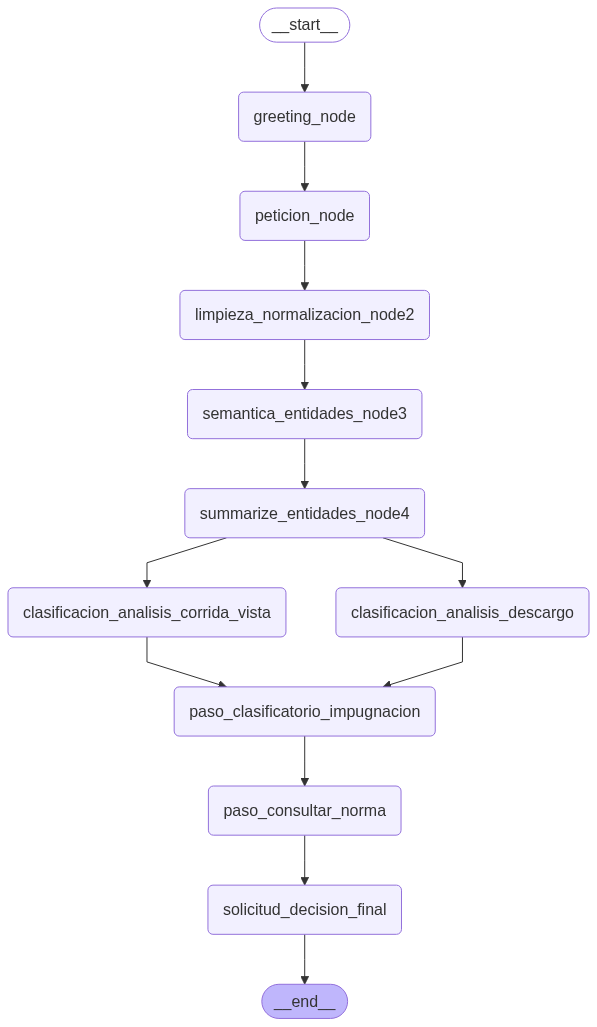

In [67]:
from IPython.display import Image, display

graph_compiled = graph.compile()

try:
    display(Image(graph_compiled.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass